# Nenana Ice Classic - Logistic Regression Modeling

In [1]:
# imports

import numpy as np
import pandas as pd

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# pipeline and preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import WOEEncoder
from sklearn.decomposition import KernelPCA as KPCA

# models
from sklearn.linear_model import LogisticRegressionCV

# evaluation
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate, cross_val_predict
from sklearn import metrics # explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

# Pretty Print to make some outputs easier to read
import pprint

# filter warnings
import warnings
warnings.filterwarnings("ignore")

import gc # garbage collection

In [2]:
def stringify(data):
    data = pd.DataFrame(data)
    for c in data.columns.tolist():
        data[c] = data[c].astype(str)
    return data

In [3]:
df = pd.read_csv('../data/features_added.csv')

In [4]:
df.head()

,Date,moonPhase,humidity,windSpeed,windBearing,uvIndex,temperatureMin,temperatureMax,precipIntensity,precipAccumulation,...,numColdDays_MA-accel5,numColdDays_MA-std_dev5,numColdDays_MA7,numColdDays_MA-slope7,numColdDays_MA-accel7,numColdDays_MA-std_dev7,numColdDays_MA10,numColdDays_MA-slope10,numColdDays_MA-accel10,numColdDays_MA-std_dev10
0,1989-03-01,0.80,0.70,8.42,236.0,1.0,20.58,29.65,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1989-03-02,0.83,0.68,8.59,266.0,1.0,-7.38,29.07,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1989-03-03,0.87,0.50,5.84,344.0,1.0,-19.23,1.84,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1989-03-04,0.90,0.51,2.52,6.0,1.0,-30.34,4.69,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1989-03-05,0.94,0.56,1.76,216.0,1.0,-38.53,0.74,0.0,0.0,...,0.714286,1.30384,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling

#### How good does my model have to be?

In [5]:
# the thing to beat: 0.9827072152653548
print('Percentage of non-events:')
1 - (df['winningDate'].sum()/df['winningDate'].count())

Percentage of non-events:


0.9827072152653548

#### Drop columns that are highly correlated
* temperatureMin and temperatureMax information was captured in temperatureAvg
* precipAccumulation information was captured in accumulatedSnow

In [6]:
df.drop(columns = ['temperatureMin', 'temperatureMax', 'precipAccumulation'],
        inplace = True)

#### Create training and testing DataFrames

In [7]:
train = df.loc[df['past'] == 1]
train.drop(columns = ['past', 'future'], inplace = True)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1399 entries, 0 to 1398
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 1.7+ MB


In [9]:
test = df.loc[df['future'] == 1]
test.drop(columns = ['past', 'future'], inplace = True)

In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278 entries, 1399 to 1676
Columns: 162 entries, Date to numColdDays_MA-std_dev10
dtypes: float64(154), int64(6), object(2)
memory usage: 354.0+ KB


In [11]:
df.drop(columns = ['past', 'future'], inplace = True)
gc.collect()

11

In [12]:
# columns to exclude from models (dates and target info)
exclude = ['winningTime', 'winningDate',  'Date']

In [13]:
used_cols = [c for c in train.columns if c not in exclude]

In [14]:
no_ma_cols = [c for c in df.columns.tolist() if not c.endswith(('3', '5', '7', '10'))]
used_no_ma_cols = [c for c in no_ma_cols if c not in exclude]

In [15]:
pprint.pprint(no_ma_cols)
pprint.pprint(used_no_ma_cols)

['Date',
 'moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'winningTime',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'winningDate',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']
['moonPhase',
 'humidity',
 'windSpeed',
 'windBearing',
 'uvIndex',
 'precipIntensity',
 'daylightHours',
 'iceThickness',
 'dayOfYear',
 'precip_rain',
 'precip_snow',
 'temperatureAvg',
 'numHotDays',
 'numColdDays',
 'accumulatedSnow']


In [16]:
train.dropna(inplace = True)

In [17]:
test.dropna(inplace = True)

In [18]:
gc.collect()

0

---
#### Logistic Regression Baseline Model Excluding Moving Average Features

In [19]:
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = train[used_no_ma_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# baseline results
# f1: 0.17566261082814563 +/- 0.09074230100606963
# f1_weighted: 0.9275518836610341 +/- 0.007584793009453831
# precision: 0.1045066045066045 +/- 0.05420993596962993
# precision_weighted: 0.9726686346039 +/- 0.00453892463009185
# recall: 0.5599999999999999 +/- 0.29393876913398137
# recall_weighted: 0.89347064292355 +/- 0.013102423629736699
# accuracy: 0.89347064292355 +/- 0.013102423629736699
# roc_auc: 0.8834917525003732 +/- 0.05619510806762218

f1: 0.17566261082814563 +/- 0.09074230100606963
f1_weighted: 0.9275518836610341 +/- 0.007584793009453831
precision: 0.1045066045066045 +/- 0.05420993596962993
precision_weighted: 0.9726686346039 +/- 0.00453892463009185
recall: 0.5599999999999999 +/- 0.29393876913398137
recall_weighted: 0.89347064292355 +/- 0.013102423629736699
accuracy: 0.89347064292355 +/- 0.013102423629736699
roc_auc: 0.8834917525003732 +/- 0.05619510806762218


lorem ipsum

In [20]:
pipe.fit(X_train, y_train)
X_test = test[used_no_ma_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [21]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.8969957081545065
Test set balanced_accuracy: 0.6539473684210526


lorem ipsum

In [22]:
sns.set_style("whitegrid", {'axes.grid' : False})

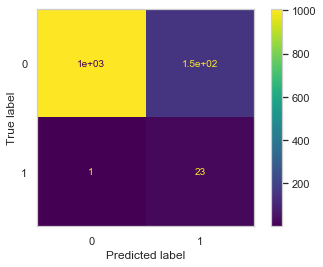

In [23]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

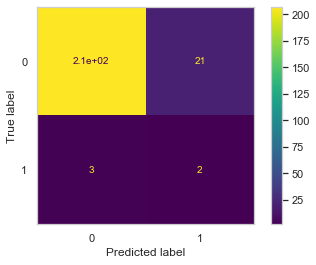

In [24]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

lorem ipsum

In [25]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([7.58113064e-04, 5.12488700e-05, 1.40169819e-04, 1.58936281e-03,
       8.28937736e-04])

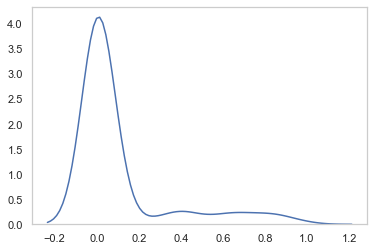

In [26]:
sns.kdeplot(y_pred);

In [118]:
metrics.confusion_matrix(y_test, y_pred > 1e-3)

array([[161,  67],
       [  0,   5]])

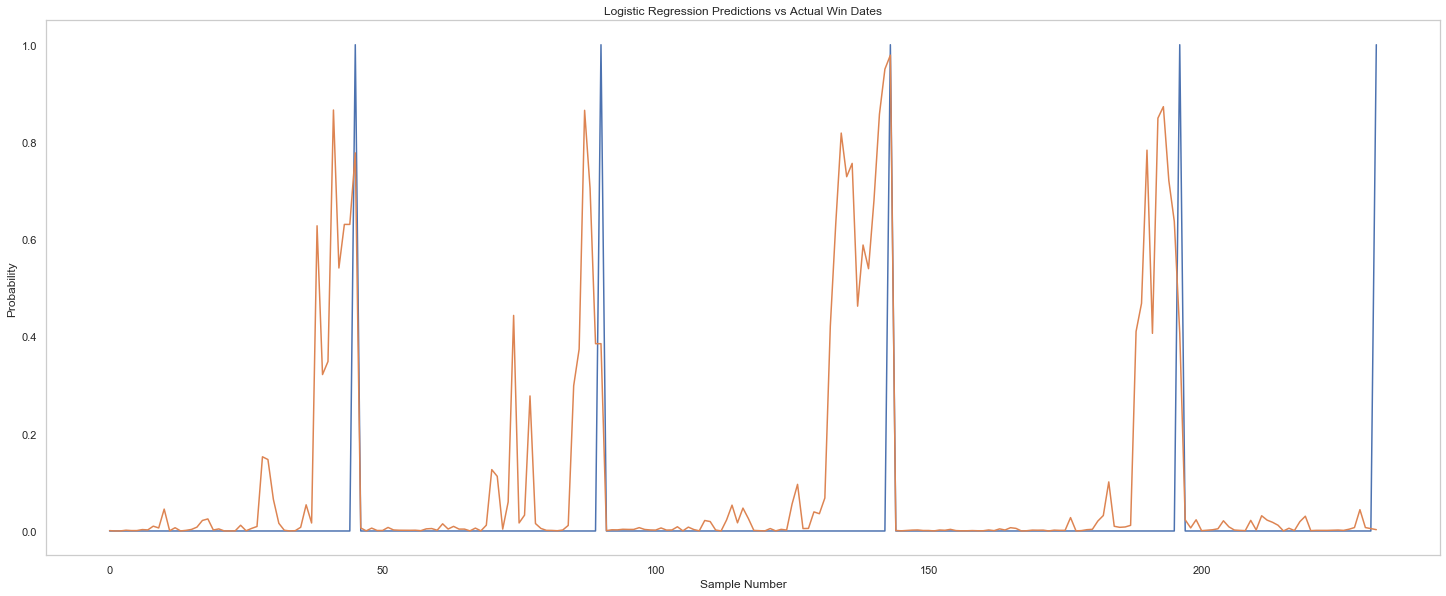

In [28]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

lorem ipsum

In [29]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)

[(13, 2.0375735061419484),
 (14, -1.9951827561425215),
 (3, 1.7479481184185908),
 (0, 1.5792839407674724),
 (2, 1.4594368681638288),
 (7, 1.3567292858295634),
 (8, 1.0957220540414823),
 (11, 0.9598944765778575),
 (4, 0.7808876681905104),
 (1, 0.22621852423921257),
 (5, 0.13704937702757172),
 (9, 0.13704937702757172),
 (10, 0.13704937702757172),
 (6, -0.10021461184895951),
 (12, 0.08925507917265287)]

In [30]:
# list the feature names so the top feature list can be made
feature_names = []
for n, v in enumerate(used_no_ma_cols):
    feature_names.append((n, v))
pprint.pprint(feature_names, compact = True)

[(0, 'moonPhase'), (1, 'humidity'), (2, 'windSpeed'), (3, 'windBearing'),
 (4, 'uvIndex'), (5, 'precipIntensity'), (6, 'daylightHours'),
 (7, 'iceThickness'), (8, 'dayOfYear'), (9, 'precip_rain'), (10, 'precip_snow'),
 (11, 'temperatureAvg'), (12, 'numHotDays'), (13, 'numColdDays'),
 (14, 'accumulatedSnow')]


In [31]:
best_no_ma_features = ['numColdDays', 'accumulatedSnow', 'daylightHours', 'windSpeed',
                       'iceThickness', 'dayOfYear', 'temperatureAvg']

---
#### Logistic Regression Model Using Top Features From Baseline Excluding Moving Average Features Model

In [32]:
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = train[best_no_ma_features].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# best features results
# f1: 0.2515499105820818 +/- 0.0341507383501873
# f1_weighted: 0.9269325385169072 +/- 0.0174099075338425
# precision: 0.14918685533698148 +/- 0.026727583355743705
# precision_weighted: 0.980009593013335 +/- 0.004157217805424703
# recall: 0.8800000000000001 +/- 0.16
# recall_weighted: 0.8909461488950869 +/- 0.029567055549800325
# accuracy: 0.8909461488950869 +/- 0.029567055549800325
# roc_auc: 0.9354589304373787 +/- 0.01936793908452841

f1: 0.2515499105820818 +/- 0.0341507383501873
f1_weighted: 0.9269325385169072 +/- 0.0174099075338425
precision: 0.14918685533698148 +/- 0.026727583355743705
precision_weighted: 0.980009593013335 +/- 0.004157217805424703
recall: 0.8800000000000001 +/- 0.16
recall_weighted: 0.8909461488950869 +/- 0.029567055549800325
accuracy: 0.8909461488950869 +/- 0.029567055549800325
roc_auc: 0.9354589304373787 +/- 0.01936793908452841


lorem ipsum

In [33]:
pipe.fit(X_train, y_train)
X_test = test[best_no_ma_features]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [34]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.8884120171673819
Test set balanced_accuracy: 0.8451754385964912


lorem ipsum

In [35]:
sns.set_style("whitegrid", {'axes.grid' : False})

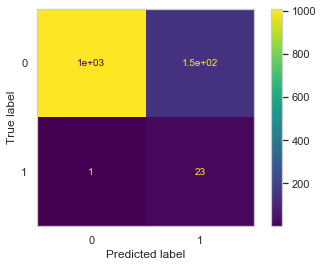

In [36]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

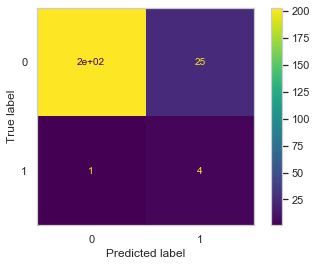

In [37]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

lorem ipsum

In [38]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([0.00097478, 0.00097478, 0.00638756, 0.00209894, 0.00209894])

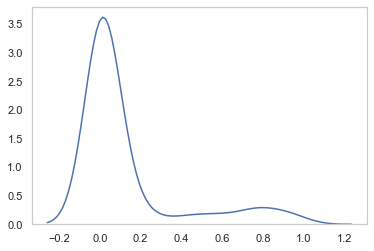

In [39]:
sns.kdeplot(y_pred);

In [40]:
metrics.confusion_matrix(y_test, y_pred > 0.15)

array([[190,  38],
       [  1,   4]])

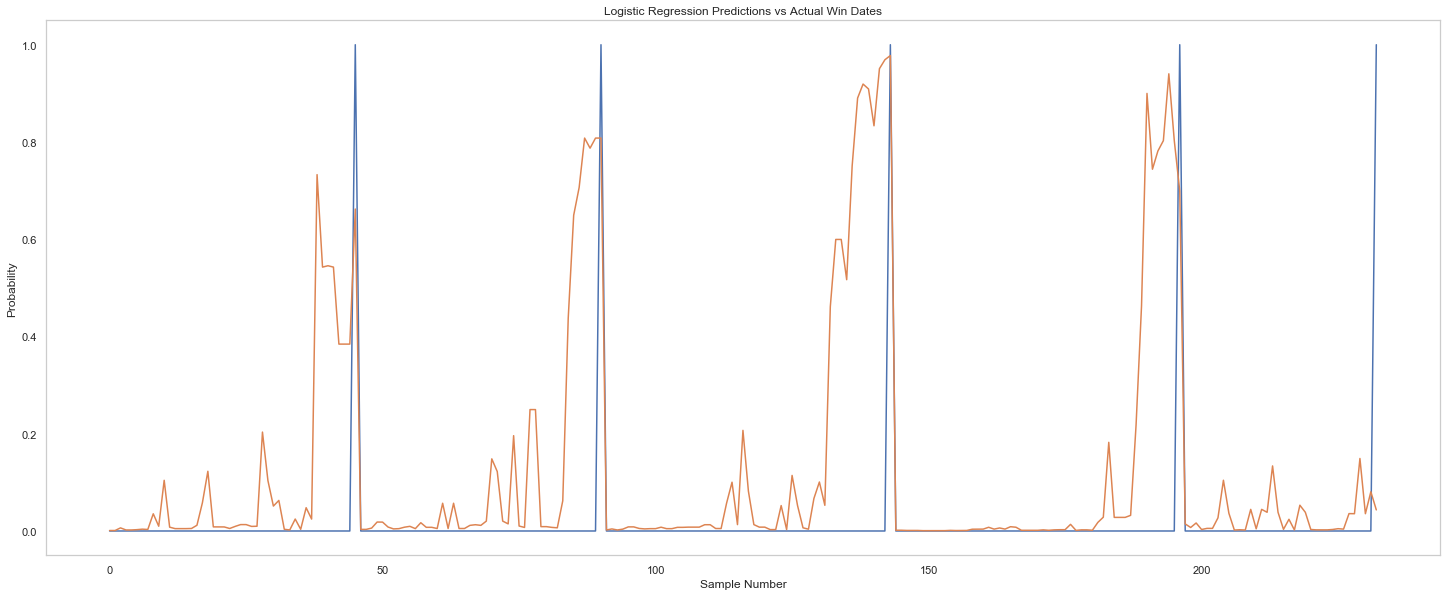

In [41]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

lorem ipsum

---
#### Baseline Logistic Regression Model Including Moving Average Features

In [42]:
# baseline Logistic Regression model using all features
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced', # class imbalance in data
                              cv = TimeSeriesSplit(), # time series, so use TimeSeriesSplit
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = train[used_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())


# the thing to beat: 0.9827072152653548 accuracy

# All features including moving average features
# f1: 0.1942857142857143 +/- 0.24404750290357285
# f1_weighted: 0.9686201962755969 +/- 0.009644453872630337
# precision: 0.27999999999999997 +/- 0.3919183588453085
# precision_weighted: 0.9687801729140142 +/- 0.01121281553977499
# recall: 0.16 +/- 0.19595917942265426
# recall_weighted: 0.9695666166058785 +/- 0.010140209522678734
# accuracy: 0.9695666166058785 +/- 0.010140209522678734
# roc_auc: 0.8198458725182862 +/- 0.09397218676228067

f1: 0.1942857142857143 +/- 0.24404750290357285
f1_weighted: 0.9686201962755969 +/- 0.009644453872630337
precision: 0.27999999999999997 +/- 0.3919183588453085
precision_weighted: 0.9687801729140142 +/- 0.01121281553977499
recall: 0.16 +/- 0.19595917942265426
recall_weighted: 0.9695666166058785 +/- 0.010140209522678734
accuracy: 0.9695666166058785 +/- 0.010140209522678734
roc_auc: 0.8198458725182862 +/- 0.09397218676228067


In [43]:
pipe.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [44]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9742489270386266
Test set balanced_accuracy: 0.5956140350877193


In [45]:
sns.set_style("whitegrid", {'axes.grid' : False})

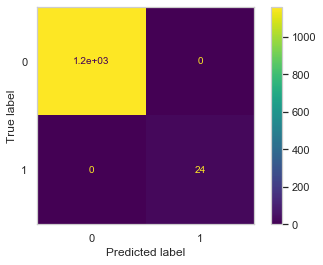

In [46]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

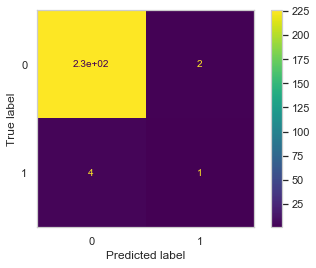

In [47]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [48]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([2.24125772e-15, 4.81953709e-13, 4.29567045e-09, 1.52868210e-11,
       2.30724203e-08])

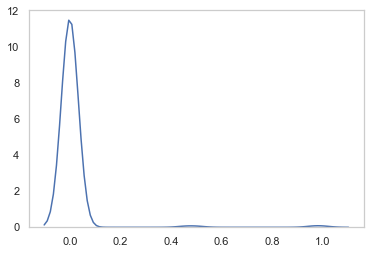

In [49]:
sns.kdeplot(y_pred);

In [50]:
metrics.confusion_matrix(y_test, y_pred > 1e-10)

array([[137,  91],
       [  1,   4]])

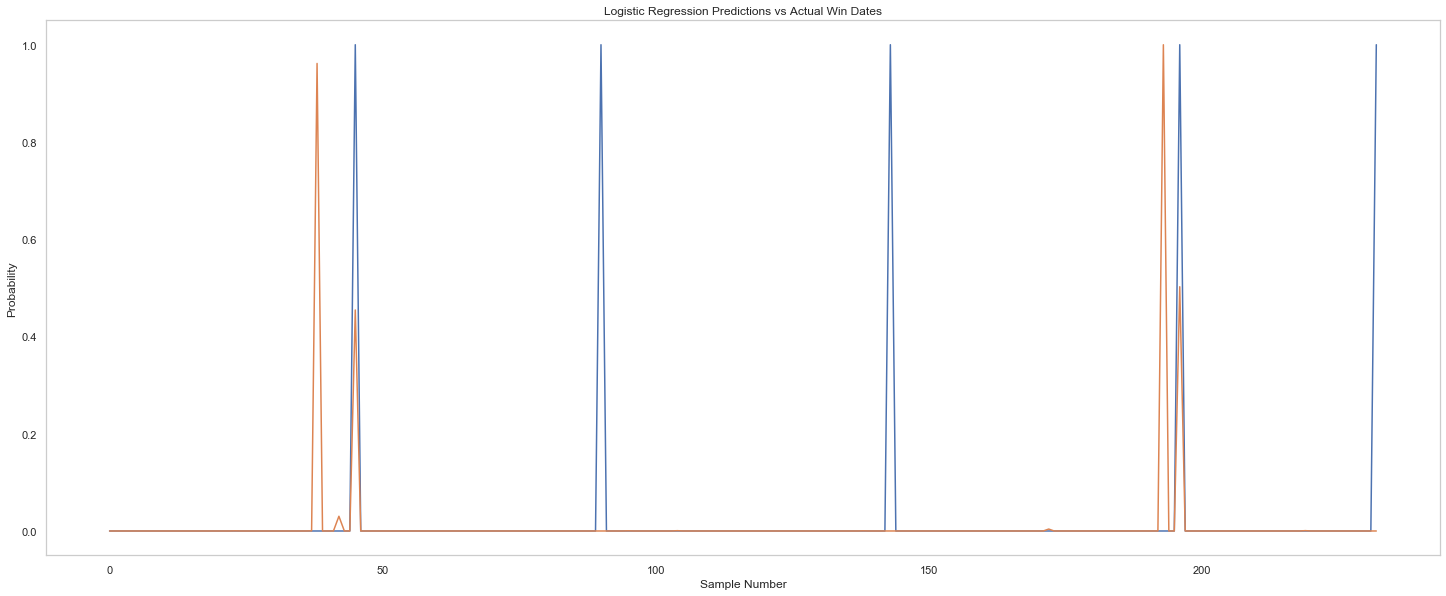

In [51]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

Based on the confusion matrices, this model is overfitted.

In [52]:
pprint.pprint(used_cols, compact = True)

['moonPhase', 'humidity', 'windSpeed', 'windBearing', 'uvIndex',
 'precipIntensity', 'daylightHours', 'iceThickness', 'dayOfYear', 'precip_rain',
 'precip_snow', 'temperatureAvg', 'numHotDays', 'numColdDays',
 'accumulatedSnow', 'humidity_MA3', 'humidity_MA-slope3', 'humidity_MA-accel3',
 'humidity_MA-std_dev3', 'humidity_MA5', 'humidity_MA-slope5',
 'humidity_MA-accel5', 'humidity_MA-std_dev5', 'humidity_MA7',
 'humidity_MA-slope7', 'humidity_MA-accel7', 'humidity_MA-std_dev7',
 'humidity_MA10', 'humidity_MA-slope10', 'humidity_MA-accel10',
 'humidity_MA-std_dev10', 'windSpeed_MA3', 'windSpeed_MA-slope3',
 'windSpeed_MA-accel3', 'windSpeed_MA-std_dev3', 'windSpeed_MA5',
 'windSpeed_MA-slope5', 'windSpeed_MA-accel5', 'windSpeed_MA-std_dev5',
 'windSpeed_MA7', 'windSpeed_MA-slope7', 'windSpeed_MA-accel7',
 'windSpeed_MA-std_dev7', 'windSpeed_MA10', 'windSpeed_MA-slope10',
 'windSpeed_MA-accel10', 'windSpeed_MA-std_dev10', 'windBearing_MA3',
 'windBearing_MA-slope3', 'windBearing_MA-acce

---
#### Initial Approach
At this point, feature dimensionality was high. Initially, I dealt with it by fitting the model and pulling out the most important features by hand (measured by coefficient weights).

In [53]:
# get the top features by coefficient
feature_values = []
for n, v in enumerate(clf_lr.coef_[0]):
    feature_values.append((n, v))
sorted(feature_values, key = lambda x: abs(x[1]), reverse = True)[:51]

[(43, -1.5445106366472545),
 (136, 1.4572049232523723),
 (120, 1.4489460924939832),
 (11, 1.4413606462772908),
 (40, 1.407558185303181),
 (58, -1.3765732951685825),
 (92, 1.3668363722286203),
 (85, 1.331675344571612),
 (19, 1.3279697869790457),
 (18, 1.327636416741558),
 (57, 1.2957506774276093),
 (125, 1.2546516320688306),
 (3, 1.2516940234577374),
 (118, 1.199291624278902),
 (60, 1.188165704869015),
 (106, 1.164212443799455),
 (67, -1.1319644109073854),
 (97, 1.107173309223184),
 (133, 1.0914422421448378),
 (69, -1.0794019588672652),
 (34, -1.077306623949587),
 (145, -1.0620347056066315),
 (2, -1.0313349735079953),
 (142, 1.0268719510009092),
 (116, 1.0261810298858836),
 (113, 1.014227132950499),
 (93, -0.9986088411607159)]

In [54]:
# list the feature names so the top 30 feature list can be made
feature_names = []
for n, v in enumerate(used_cols):
    feature_names.append((n, v))
pprint.pprint(feature_names, compact = True)

[(0, 'moonPhase'), (1, 'humidity'), (2, 'windSpeed'), (3, 'windBearing'),
 (4, 'uvIndex'), (5, 'precipIntensity'), (6, 'daylightHours'),
 (7, 'iceThickness'), (8, 'dayOfYear'), (9, 'precip_rain'), (10, 'precip_snow'),
 (11, 'temperatureAvg'), (12, 'numHotDays'), (13, 'numColdDays'),
 (14, 'accumulatedSnow'), (15, 'humidity_MA3'), (16, 'humidity_MA-slope3'),
 (17, 'humidity_MA-accel3'), (18, 'humidity_MA-std_dev3'), (19, 'humidity_MA5'),
 (20, 'humidity_MA-slope5'), (21, 'humidity_MA-accel5'),
 (22, 'humidity_MA-std_dev5'), (23, 'humidity_MA7'), (24, 'humidity_MA-slope7'),
 (25, 'humidity_MA-accel7'), (26, 'humidity_MA-std_dev7'),
 (27, 'humidity_MA10'), (28, 'humidity_MA-slope10'),
 (29, 'humidity_MA-accel10'), (30, 'humidity_MA-std_dev10'),
 (31, 'windSpeed_MA3'), (32, 'windSpeed_MA-slope3'),
 (33, 'windSpeed_MA-accel3'), (34, 'windSpeed_MA-std_dev3'),
 (35, 'windSpeed_MA5'), (36, 'windSpeed_MA-slope5'),
 (37, 'windSpeed_MA-accel5'), (38, 'windSpeed_MA-std_dev5'),
 (39, 'windSpeed_MA7

In [55]:
# Top 20 features by coefficient
lr_best_cols = ['humidity_MA-std_dev10', 'windBearing_MA-accel10', 'windSpeed_MA-accel7', 'accumulatedSnow', 'windSpeed_MA-std_dev10',
                'uvIndex_MA-std_dev10', 'humidity_MA-accel3', 'windBearing_MA-slope3', 'temperatureAvg_MA-slope3', 'windSpeed_MA-slope3',
                'temperatureAvg_MA7', 'windSpeed_MA5', 'temperatureAvg_MA-accel7', 'uvIndex_MA-slope7', 'temperatureAvg_MA10',
                'numHotDays_MA-accel3', 'windSpeed_MA7', 'windBearing_MA-std_dev10', 'numColdDays_MA-std_dev5', 'windSpeed_MA-std_dev5']

In [56]:
# check correlations in top 20 features
train[lr_best_cols].corr()

,humidity_MA-std_dev10,windBearing_MA-accel10,windSpeed_MA-accel7,accumulatedSnow,windSpeed_MA-std_dev10,uvIndex_MA-std_dev10,humidity_MA-accel3,windBearing_MA-slope3,temperatureAvg_MA-slope3,windSpeed_MA-slope3,temperatureAvg_MA7,windSpeed_MA5,temperatureAvg_MA-accel7,uvIndex_MA-slope7,temperatureAvg_MA10,numHotDays_MA-accel3,windSpeed_MA7,windBearing_MA-std_dev10,numColdDays_MA-std_dev5,windSpeed_MA-std_dev5
humidity_MA-std_dev10,1.000000,0.002553,0.008206,0.141324,0.309508,0.039723,-0.002406,0.007596,-0.039123,0.002258,-0.009074,0.077619,0.003363,-0.007769,0.011775,-0.014661,0.085221,0.022343,0.053026,0.202402
windBearing_MA-accel10,0.002553,1.000000,-0.074744,-0.010242,0.016052,0.020266,-0.008472,0.453095,-0.223695,-0.090400,0.108894,0.037285,-0.270281,-0.066359,0.060108,-0.104430,0.070998,0.003014,-0.081288,0.036175
windSpeed_MA-accel7,0.008206,-0.074744,1.000000,0.001420,0.005150,-0.003317,-0.023754,-0.106864,0.101020,0.649114,-0.002804,-0.227041,0.198968,0.022024,0.002194,-0.000417,-0.082454,0.025001,0.019308,-0.091748
accumulatedSnow,0.141324,-0.010242,0.001420,1.000000,-0.174879,0.111330,-0.007352,-0.010027,0.013589,-0.008258,0.058856,-0.166935,0.008388,-0.020248,0.059681,0.019966,-0.168947,-0.080550,-0.088141,-0.141371
windSpeed_MA-std_dev10,0.309508,0.016052,0.005150,-0.174879,1.000000,-0.142821,0.010812,0.017543,-0.015841,-0.018619,-0.142661,0.563139,0.001152,-0.038917,-0.139437,-0.010330,0.607490,0.208153,0.140655,0.735121
uvIndex_MA-std_dev10,0.039723,0.020266,-0.003317,0.111330,-0.142821,1.000000,0.004167,0.013719,0.024392,0.006105,0.384669,-0.065899,-0.016872,0.406239,0.383659,0.033028,-0.078214,0.017722,-0.270415,-0.090836
humidity_MA-accel3,-0.002406,-0.008472,-0.023754,-0.007352,0.010812,0.004167,1.000000,0.127988,0.051801,-0.066151,-0.007988,0.020329,0.016260,0.036944,-0.006976,-0.045306,0.014131,0.000204,0.014290,-0.003598
windBearing_MA-slope3,0.007596,0.453095,-0.106864,-0.010027,0.017543,0.013719,0.127988,1.000000,-0.107163,-0.159190,0.040436,0.032687,-0.009689,-0.023061,0.031569,-0.116531,0.034911,-0.007352,-0.037233,0.026908
temperatureAvg_MA-slope3,-0.039123,-0.223695,0.101020,0.013589,-0.015841,0.024392,0.051801,-0.107163,1.000000,0.230362,-0.104714,-0.029617,0.708019,0.111230,-0.095344,0.231718,-0.039956,0.002357,0.105918,-0.022455
windSpeed_MA-slope3,0.002258,-0.090400,0.649114,-0.008258,-0.018619,0.006105,-0.066151,-0.159190,0.230362,1.000000,0.006024,-0.070303,0.157098,0.055487,0.008790,0.080744,-0.067077,0.032843,0.024591,0.005004


This resulted in some collinear features, as well as inter-related features.

#### Reminder To Self : What The Metrics Mean
* F1 = harmonic mean of precision and recall (2 * (precision * recall / precision + recall))
  * A higher score means better positive predictive power and/or higher true positive rate.
* precision = correct_pos_preds / total_pos_preds (percent correct of all positive predictions; positive predictive power)
  * A higher score means the proportion of correct positive predictions to total positive predictions is better.
* recall = correct_pos_preds / total_actual_positives (True Positive Rate)
  * A higher score means the proportion of correct positive predictions to the total of actual positive instances is better.
* accuracy = percentage of correct classifications
  * A higher score means more correct predictions of the actual classifications.
* roc_auc = https://en.wikipedia.org/wiki/Receiver_operating_characteristic ("When using normalized units, the area under the curve (often referred to as simply the AUC) is equal to the probability that a classifier will rank a randomly chosen positive instance higher than a randomly chosen negative one (assuming 'positive' ranks higher than 'negative').")
  * A higher score means that the classifier is more likely to rank the positive instance higher (correctly?) when given a random positive instance and a random negative instance.

---
#### Logistic Regression Model Using Top 20 Features From Baseline Model

In [57]:
# used_cols = ['daylightHours', 'windSpeed', 'dayOfYear', 'temperatureAvg', 'iceThickness', 'accumulatedSnow']
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = train[lr_best_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# top 20 features
# f1: 0.13255411255411256 +/- 0.14165422974123695
# f1_weighted: 0.9583942853145642 +/- 0.008933170131453847
# precision: 0.0919047619047619 +/- 0.09499492766026583
# precision_weighted: 0.9661791400453849 +/- 0.008597365034417097
# recall: 0.25 +/- 0.2932575659723036
# recall_weighted: 0.952663949081027 +/- 0.017173903823321162
# accuracy: 0.952663949081027 +/- 0.017173903823321162
# roc_auc: 0.8990069413345274 +/- 0.040123900769389265

f1: 0.13255411255411256 +/- 0.14165422974123695
f1_weighted: 0.9583942853145642 +/- 0.008933170131453847
precision: 0.0919047619047619 +/- 0.09499492766026583
precision_weighted: 0.9661791400453849 +/- 0.008597365034417097
recall: 0.25 +/- 0.2932575659723036
recall_weighted: 0.952663949081027 +/- 0.017173903823321162
accuracy: 0.952663949081027 +/- 0.017173903823321162
roc_auc: 0.8990069413345274 +/- 0.040123900769389265


The mean accuracy score increased but the standard deviation of the accuracy scores also increased.

In [58]:
pipe.fit(X_train, y_train)
X_test = test[lr_best_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [59]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9613733905579399
Test set balanced_accuracy: 0.6868421052631579


Test set accuracy went down but balanced accuracy went up with the top 20 model.

In [60]:
sns.set_style("whitegrid", {'axes.grid' : False})

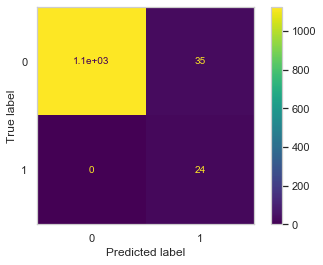

In [61]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

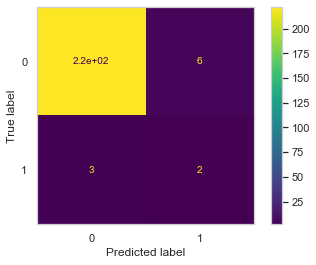

In [62]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

This confusion matrix looks slightly better than the previous model's.

In [63]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([4.52304540e-23, 6.17042811e-19, 1.81535935e-14, 2.62560279e-23,
       1.79807510e-17])

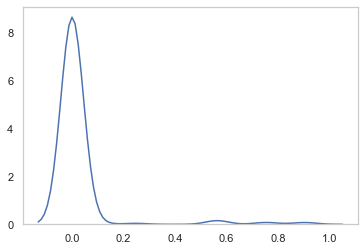

In [64]:
sns.kdeplot(y_pred);

In [65]:
metrics.confusion_matrix(y_test, y_pred > 0.15)

array([[221,   7],
       [  3,   2]])

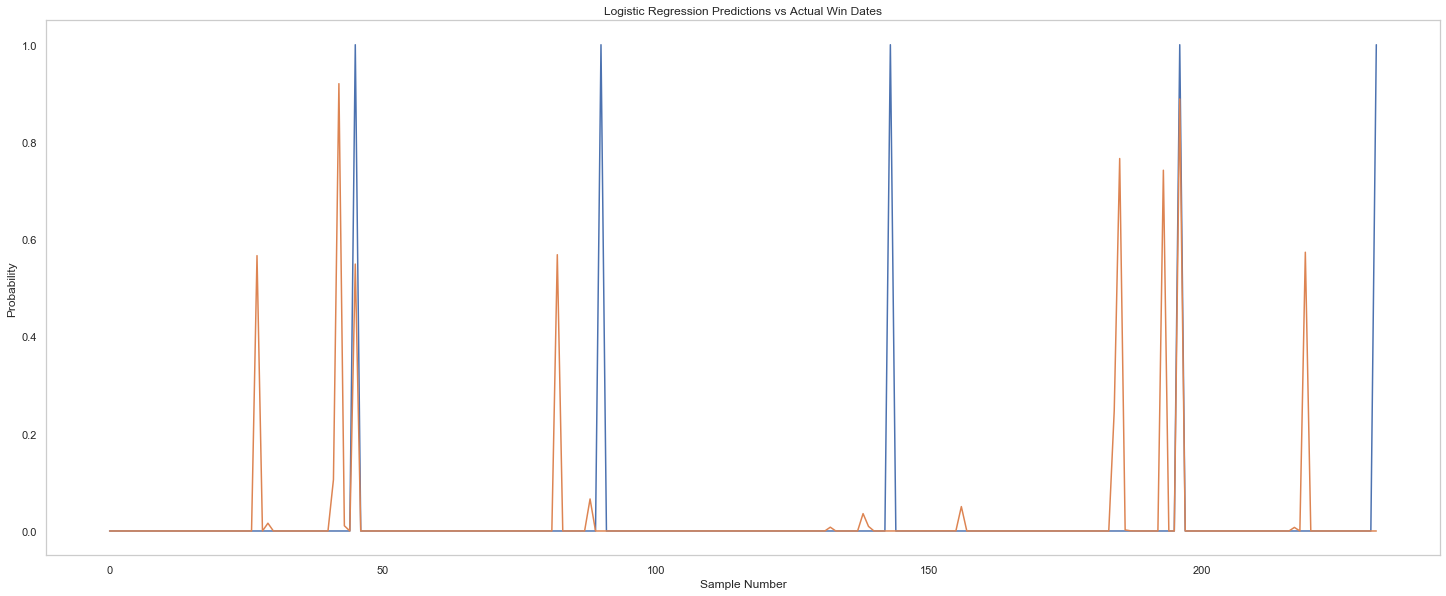

In [66]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

This probability plot looks better than the baseline model's.

Based on the confusion matrices, this model is still overfitted, though not as badly as the baseline model.

---
#### Logistic Regression Model Using Adjusted Best Feature List
I decided to exclude features that derived from the same base. I thought this might reduce overfitting by diversifying the base features used.

(30, 'humidity_MA-std_dev10')
(61, 'windBearing_MA-accel10')
(41, 'windSpeed_MA-accel7')
(14, 'accumulatedSnow')
    ~~(46, 'windSpeed_MA-std_dev10')~~
(78, 'uvIndex_MA-std_dev10')
    ~~(17, 'humidity_MA-accel3')~~
    ~~(48, 'windBearing_MA-slope3')~~
(112, 'temperatureAvg_MA-slope3')
    ~~(32, 'windSpeed_MA-slope3')~~
    ~~(119, 'temperatureAvg_MA7')~~
    ~~(35, 'windSpeed_MA5')~~
    ~~(121, 'temperatureAvg_MA-accel7')~~
    ~~(72, 'uvIndex_MA-slope7')~~
    ~~(123, 'temperatureAvg_MA10')~~
(129, 'numHotDays_MA-accel3')
    ~~(39, 'windSpeed_MA7')~~
    ~~(62, 'windBearing_MA-std_dev10')~~
(150, 'numColdDays_MA-std_dev5')
    ~~(38, 'windSpeed_MA-std_dev5')~~
    ~~(138, 'numHotDays_MA-std_dev7')~~
    ~~(68, 'uvIndex_MA-slope5')~~
    ~~(45, 'windSpeed_MA-accel10')~~
    ~~(27, 'humidity_MA10')~~
    ~~(153, 'numColdDays_MA-accel7')~~
    ~~(117, 'temperatureAvg_MA-accel5')~~
(94, 'precipIntensity_MA-std_dev10')
    ~~(21, 'humidity_MA-accel5')~~
    ~~(56, 'windBearing_MA-slope7')~~
    ~~(23, 'humidity_MA7')~~
    ~~(54, 'windBearing_MA-std_dev5')~~
    ~~(127, 'numHotDays_MA3')~~
    ~~(47, 'windBearing_MA3')~~
    ~~(44, 'windSpeed_MA-slope10')~~
(108, 'iceThickness_MA-slope10')
    ~~(149, 'numColdDays_MA-accel5')~~
    ~~(28, 'humidity_MA-slope10')~~
    ~~(109, 'iceThickness_MA-accel10')~~
    ~~(149, 'numColdDays_MA-accel5')~~
    ~~(28, 'humidity_MA-slope10')~~
    ~~(109, 'iceThickness_MA-accel10')~~
    ~~(111, 'temperatureAvg_MA3')~~
    ~~(77, 'uvIndex_MA-accel10')~~
    ~~(20, 'humidity_MA-slope5')~~
    ~~(115, 'temperatureAvg_MA5')~~
    ~~(75, 'uvIndex_MA10')~~
(6, 'daylightHours')
    ~~(52, 'windBearing_MA-slope5')~~
    ~~(50, 'windBearing_MA-std_dev3')~~
    ~~(36, 'windSpeed_MA-slope5')~~
    ~~(55, 'windBearing_MA7')~~
    ~~(16, 'humidity_MA-slope3')~~
    ~~(43, 'windSpeed_MA10')~~

extra
(8, 'dayOfYear')

In [67]:
# top diverse features
adj_lr_best_cols = ['humidity_MA-std_dev10', 'windBearing_MA-accel10', 'windSpeed_MA-accel7', 'accumulatedSnow', 'uvIndex_MA-std_dev10',
                    'temperatureAvg_MA-slope3', 'numHotDays_MA-accel3', 'numColdDays_MA-std_dev5', 'precipIntensity_MA-std_dev10',
                    'iceThickness_MA-slope10', 'daylightHours', 'dayOfYear']

In [68]:
# Logistic Regression model using top diverse features from baseline
# used_cols = ['daylightHours', 'windSpeed', 'dayOfYear', 'temperatureAvg', 'iceThickness', 'accumulatedSnow']
target = 'winningDate'

scaler = RobustScaler()
encoder = WOEEncoder()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)
pipe = make_pipeline(scaler, binner, objectify, encoder, clf_lr)

X_train, y_train = train[adj_lr_best_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# adjusted diverse features
# f1: 0.28282202833286424 +/- 0.056811318837714175
# f1_weighted: 0.9496499180256912 +/- 0.014848999779060389
# precision: 0.18589112037387898 +/- 0.04646063484506574
# precision_weighted: 0.9754504038072367 +/- 0.0031888526881466844
# recall: 0.63 +/- 0.06000000000000001
# recall_weighted: 0.9307015661875134 +/- 0.025083504304696698
# accuracy: 0.9307015661875134 +/- 0.025083504304696698
# roc_auc: 0.914360538886401 +/- 0.022707339226074114

f1: 0.28282202833286424 +/- 0.056811318837714175
f1_weighted: 0.9496499180256912 +/- 0.014848999779060389
precision: 0.18589112037387898 +/- 0.04646063484506574
precision_weighted: 0.9754504038072367 +/- 0.0031888526881466844
recall: 0.63 +/- 0.06000000000000001
recall_weighted: 0.9307015661875134 +/- 0.025083504304696698
accuracy: 0.9307015661875134 +/- 0.025083504304696698
roc_auc: 0.914360538886401 +/- 0.022707339226074114


lorem ipsum

In [69]:
pipe.fit(X_train, y_train)
X_test = test[adj_lr_best_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [70]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9699570815450643
Test set balanced_accuracy: 0.6912280701754385


In [71]:
sns.set_style("whitegrid", {'axes.grid' : False})

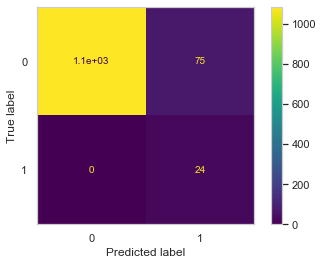

In [72]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

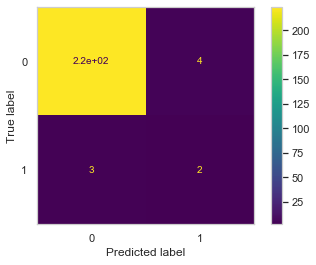

In [73]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [74]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([2.25932921e-09, 2.94290311e-07, 4.49994453e-07, 1.03834597e-08,
       4.12029857e-04])

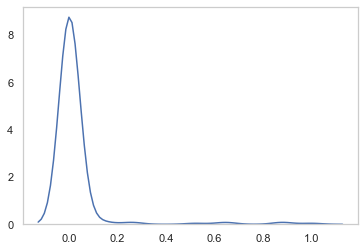

In [75]:
sns.kdeplot(y_pred);

In [76]:
metrics.confusion_matrix(y_test, y_pred > 1e-4)

array([[150,  78],
       [  1,   4]])

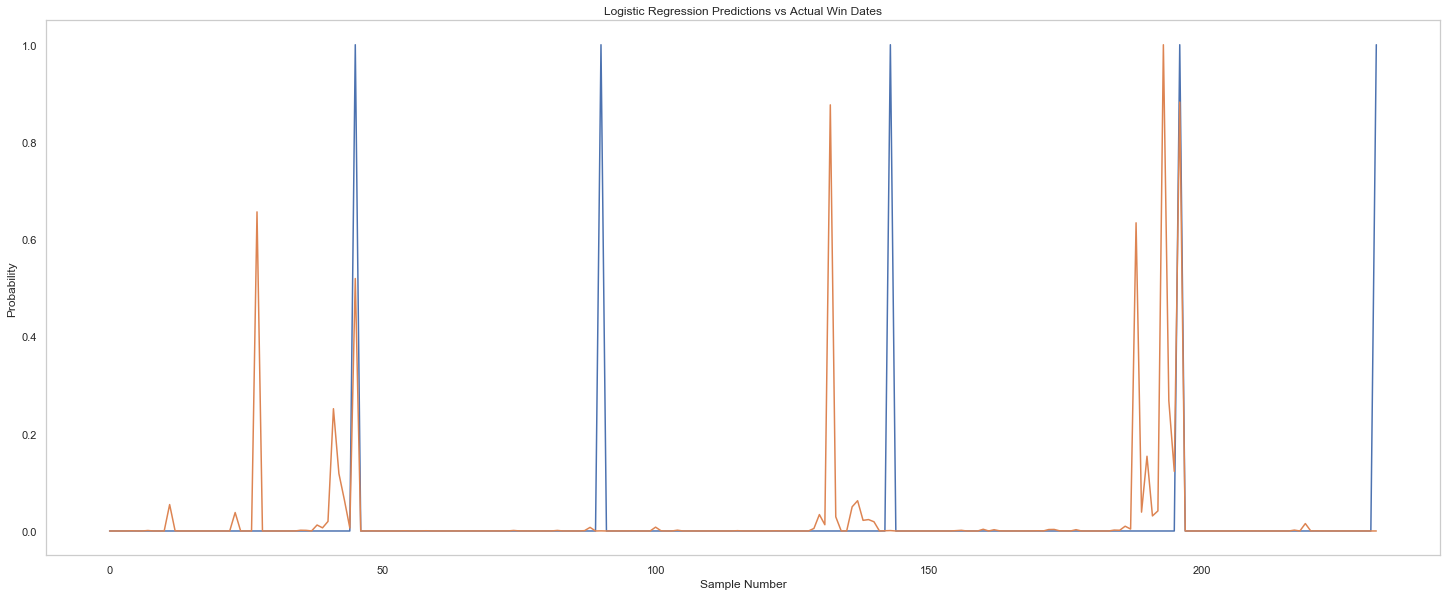

In [77]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

lorem ipsum

---
#### Principal Component Analysis
It was suggested to me that PCA would be quicker and potentially more effective than my initial approach.

In [78]:
# Logistic Regression model using PCA
# used_cols = ['daylightHours', 'windSpeed', 'dayOfYear', 'temperatureAvg', 'iceThickness', 'accumulatedSnow']
pca_exclude = ['precip_snow', 'precip_rain', 'winningDate', 'winningTime', 'Date']
used_cols = [c for c in train.columns if c not in pca_exclude]

target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 30,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = train[used_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# PCA (n_components = 30)
# f1: 0.0 +/- 0.0
# f1_weighted: 0.9632855782685856 +/- 0.0028828581332475153
# precision: 0.0 +/- 0.0
# precision_weighted: 0.9595910604523004 +/- 0.0032589102140463053
# recall: 0.0 +/- 0.0
# recall_weighted: 0.9670278194951013 +/- 0.004959071707634599
# accuracy: 0.9670278194951013 +/- 0.004959071707634599
# roc_auc: 0.8335115315718765 +/- 0.0438024202678673

f1: 0.0 +/- 0.0
f1_weighted: 0.9632855782685856 +/- 0.0028828581332475153
precision: 0.0 +/- 0.0
precision_weighted: 0.9595910604523004 +/- 0.0032589102140463053
recall: 0.0 +/- 0.0
recall_weighted: 0.9670278194951013 +/- 0.004959071707634599
accuracy: 0.9670278194951013 +/- 0.004959071707634599
roc_auc: 0.8333398641588297 +/- 0.04403371981037951


lorem ipsum

In [79]:
pipe.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [80]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9742489270386266
Test set balanced_accuracy: 0.5956140350877193


In [81]:
sns.set_style("whitegrid", {'axes.grid' : False})

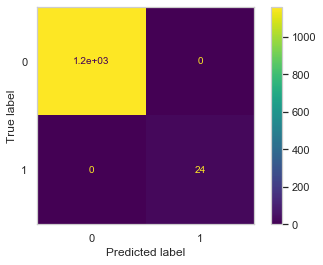

In [82]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

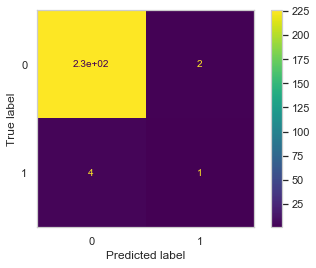

In [83]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [84]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([6.54446242e-124, 1.86395436e-113, 1.77608902e-098, 2.17668224e-100,
       5.06511037e-092])

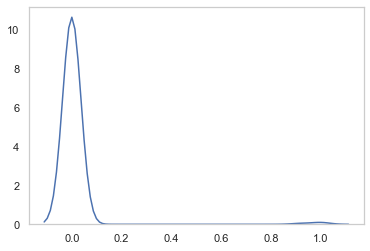

In [85]:
sns.kdeplot(y_pred);

In [86]:
metrics.confusion_matrix(y_test, y_pred > 1e-70)

array([[113, 115],
       [  1,   4]])

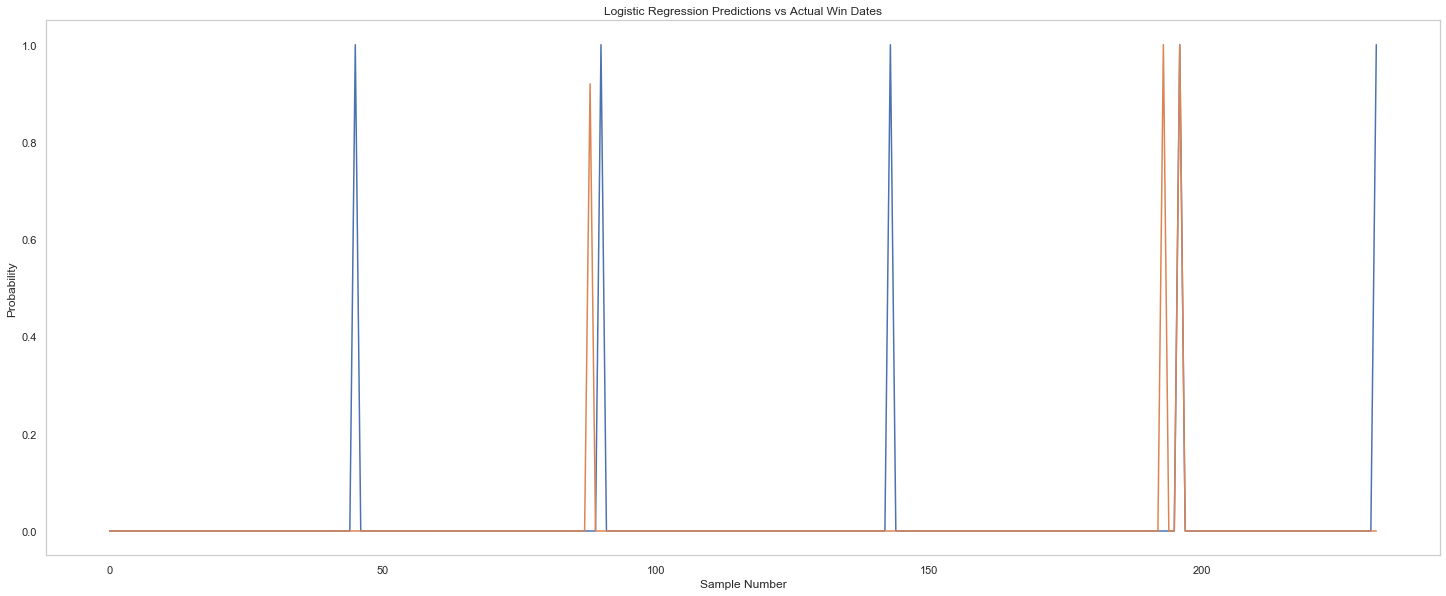

In [87]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 20 principal components

In [88]:
# Logistic Regression model using PCA
# used_cols = ['daylightHours', 'windSpeed', 'dayOfYear', 'temperatureAvg', 'iceThickness', 'accumulatedSnow']
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 20,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = train[used_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# using PCA (n_components = 20)
# f1: 0.07076923076923078 +/- 0.087894503735912
# f1_weighted: 0.9650275595495751 +/- 0.0016642239451602355
# precision: 0.06222222222222222 +/- 0.0812251861444314
# precision_weighted: 0.9624826810517593 +/- 0.0056907211559487055
# recall: 0.09 +/- 0.11135528725660043
# recall_weighted: 0.9678717013516411 +/- 0.007879654893068903
# accuracy: 0.9678717013516411 +/- 0.007879654893068903
# roc_auc: 0.8899091282280939 +/- 0.05513838140043163

f1: 0.07076923076923078 +/- 0.087894503735912
f1_weighted: 0.9650275595495751 +/- 0.0016642239451602355
precision: 0.06222222222222222 +/- 0.0812251861444314
precision_weighted: 0.9624826810517593 +/- 0.0056907211559487055
recall: 0.09 +/- 0.11135528725660043
recall_weighted: 0.9678717013516411 +/- 0.007879654893068903
accuracy: 0.9678717013516411 +/- 0.007879654893068903
roc_auc: 0.8899091282280939 +/- 0.05513838140043163


lorem ipsum

In [89]:
pipe.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [90]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9785407725321889
Test set balanced_accuracy: 0.6956140350877194


In [91]:
sns.set_style("whitegrid", {'axes.grid' : False})

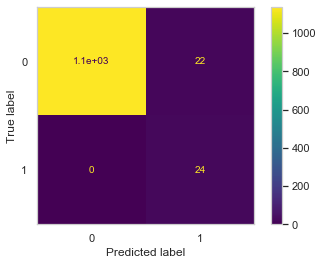

In [92]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

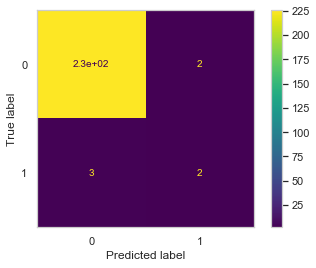

In [93]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [94]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([4.73076005e-15, 1.71486296e-18, 5.14015909e-15, 3.07282778e-15,
       2.23249392e-12])

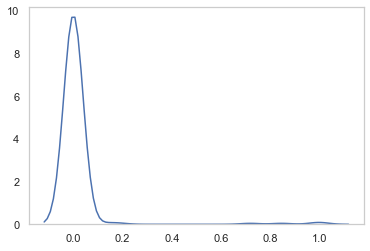

In [95]:
sns.kdeplot(y_pred);

In [96]:
metrics.confusion_matrix(y_test, y_pred > 1e-8)

array([[130,  98],
       [  1,   4]])

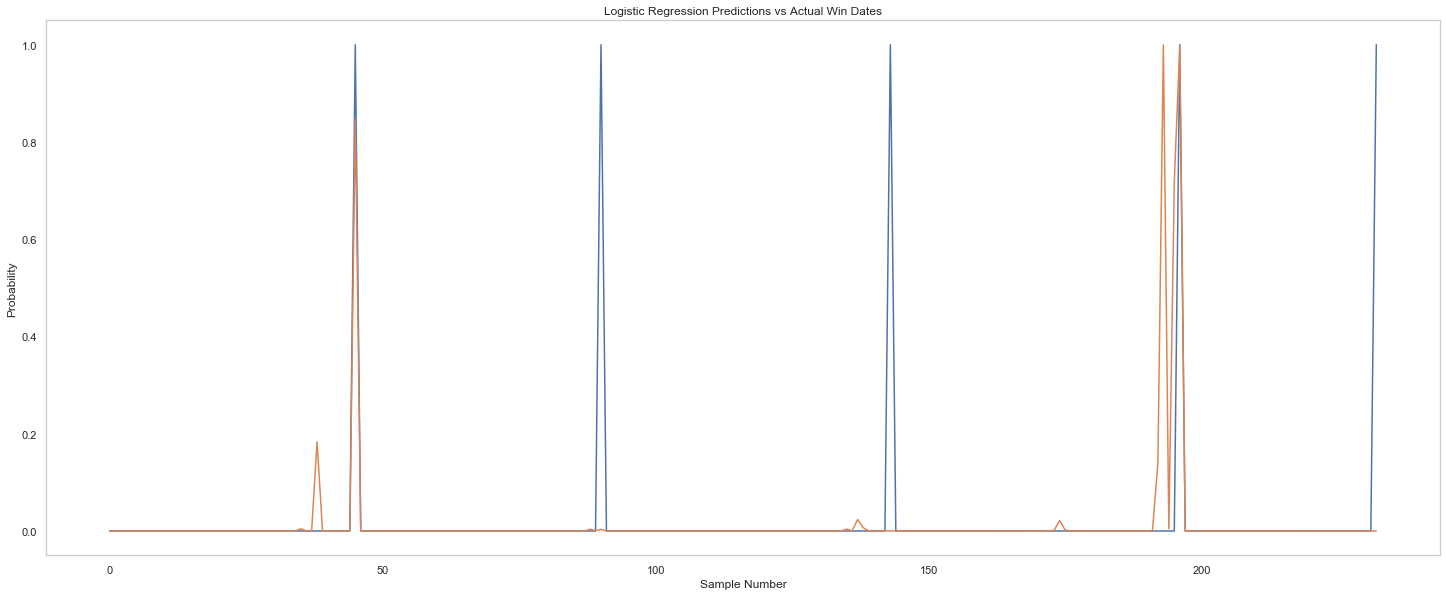

In [97]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 10 principal components

In [98]:
# Logistic Regression model using PCA
# used_cols = ['daylightHours', 'windSpeed', 'dayOfYear', 'temperatureAvg', 'iceThickness', 'accumulatedSnow']
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 10,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = train[used_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# using PCA (n_components = 10)
# f1: 0.22802968960863695 +/- 0.1166370115347808
# f1_weighted: 0.9585028354390179 +/- 0.006085640456552704
# precision: 0.16285714285714287 +/- 0.0875284210402308
# precision_weighted: 0.9710024721251251 +/- 0.007560861712603837
# recall: 0.43 +/- 0.25219040425836986
# recall_weighted: 0.9492562397196596 +/- 0.014250216970527772
# accuracy: 0.9492562397196596 +/- 0.014250216970527772
# roc_auc: 0.9276587923570683 +/- 0.009652641502595103

f1: 0.22802968960863695 +/- 0.1166370115347808
f1_weighted: 0.9585028354390179 +/- 0.006085640456552704
precision: 0.16285714285714287 +/- 0.0875284210402308
precision_weighted: 0.9710024721251251 +/- 0.007560861712603837
recall: 0.43 +/- 0.25219040425836986
recall_weighted: 0.9492562397196596 +/- 0.014250216970527772
accuracy: 0.9492562397196596 +/- 0.014250216970527772
roc_auc: 0.9276587923570683 +/- 0.009652641502595103


lorem ipsum

In [99]:
pipe.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [100]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9613733905579399
Test set balanced_accuracy: 0.7846491228070176


In [101]:
sns.set_style("whitegrid", {'axes.grid' : False})

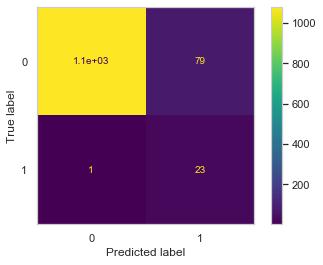

In [102]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

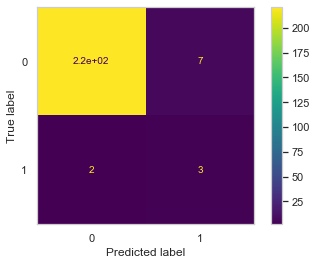

In [103]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [104]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([2.37773769e-14, 8.33538902e-14, 1.87872627e-13, 2.12476430e-13,
       4.90932396e-12])

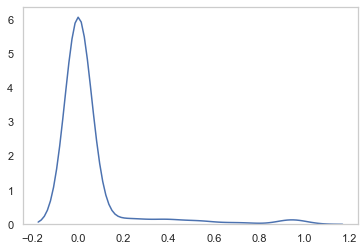

In [105]:
sns.kdeplot(y_pred);

In [106]:
metrics.confusion_matrix(y_test, y_pred > 1e-3)

array([[175,  53],
       [  0,   5]])

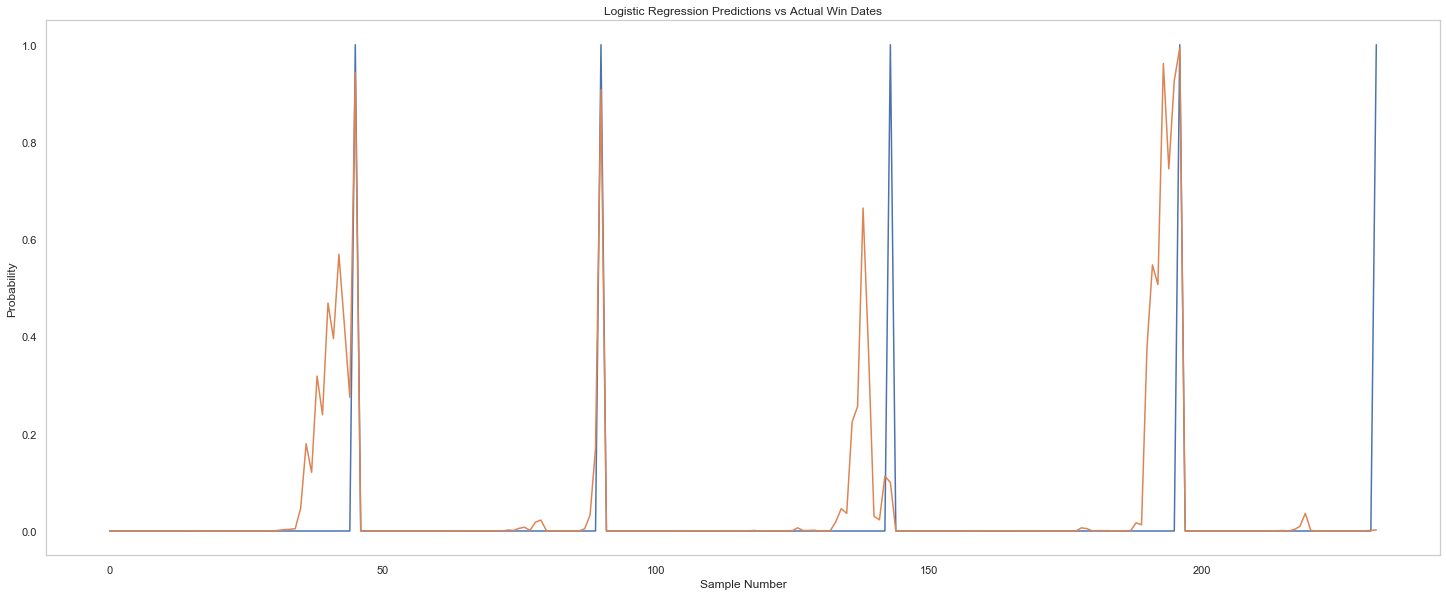

In [107]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()

---
#### Reducing The Number Of Principal Components
Experiment with 5 principal components

In [108]:
# Logistic Regression model using PCA
# used_cols = ['daylightHours', 'windSpeed', 'dayOfYear', 'temperatureAvg', 'iceThickness', 'accumulatedSnow']
target = 'winningDate'

scaler = RobustScaler()
binner = KBinsDiscretizer(n_bins=7, encode='ordinal')
objectify = FunctionTransformer(func=stringify, check_inverse=False, validate=False)
encoder = WOEEncoder()
pca = KPCA(n_components = 5,
           random_state = 42,
           n_jobs = -1)

clf_lr = LogisticRegressionCV(class_weight='balanced',
                              cv = TimeSeriesSplit(),
                              solver = 'liblinear',
                              n_jobs=-1,
                              random_state=42)

pipe = make_pipeline(scaler, binner, objectify, encoder, pca, clf_lr)

X_train, y_train = train[used_cols].values, train[target].values

scores = cross_validate(pipe, X_train, y_train, cv = 5, scoring=['f1', 'f1_weighted',
                                                                 'precision', 'precision_weighted',
                                                                 'recall', 'recall_weighted',
                                                                 'accuracy',
                                                                 'roc_auc'])

print('f1:', scores['test_f1'].mean(), '+/-', scores['test_f1'].std())
print('f1_weighted:', scores['test_f1_weighted'].mean(), '+/-', scores['test_f1_weighted'].std())
print('precision:', scores['test_precision'].mean(), '+/-', scores['test_precision'].std())
print('precision_weighted:', scores['test_precision_weighted'].mean(), '+/-',
      scores['test_precision_weighted'].std())
print('recall:', scores['test_recall'].mean(), '+/-', scores['test_recall'].std())
print('recall_weighted:', scores['test_recall_weighted'].mean(), '+/-',
      scores['test_recall_weighted'].std())
print('accuracy:', scores['test_accuracy'].mean(), '+/-',
      scores['test_accuracy'].std())
print('roc_auc:', scores['test_roc_auc'].mean(), '+/-', scores['test_roc_auc'].std())

# the thing to beat: 0.9827072152653548 accuracy

# using PCA (n_components = 5)
# f1: 0.363015381591233 +/- 0.08553921983071007
# f1_weighted: 0.9518814850039927 +/- 0.018988382110371828
# precision: 0.24534798534798535 +/- 0.07999463278162197
# precision_weighted: 0.9813138066820176 +/- 0.0025862448841939894
# recall: 0.8400000000000001 +/- 0.14966629547095767
# recall_weighted: 0.9323070871772867 +/- 0.03323031608015485
# accuracy: 0.9323070871772867 +/- 0.03323031608015485
# roc_auc: 0.959886923421406 +/- 0.018355173963055534

f1: 0.363015381591233 +/- 0.08553921983071007
f1_weighted: 0.9518814850039927 +/- 0.018988382110371828
precision: 0.24534798534798535 +/- 0.07999463278162197
precision_weighted: 0.9813138066820176 +/- 0.0025862448841939894
recall: 0.8400000000000001 +/- 0.14966629547095767
recall_weighted: 0.9323070871772867 +/- 0.03323031608015485
accuracy: 0.9323070871772867 +/- 0.03323031608015485
roc_auc: 0.959886923421406 +/- 0.018355173963055534


lorem ipsum

In [109]:
pipe.fit(X_train, y_train)
X_test = test[used_cols]
y_test = test[target]
y_pred = pipe.predict(X_test)

In [110]:
print('Test set accuracy:', metrics.accuracy_score(y_test, y_pred))
print('Test set balanced_accuracy:', metrics.balanced_accuracy_score(y_test, y_pred))

Test set accuracy: 0.9227467811158798
Test set balanced_accuracy: 0.862719298245614


In [111]:
sns.set_style("whitegrid", {'axes.grid' : False})

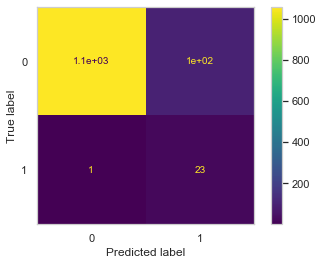

In [112]:
metrics.plot_confusion_matrix(pipe, X_train, y_train);

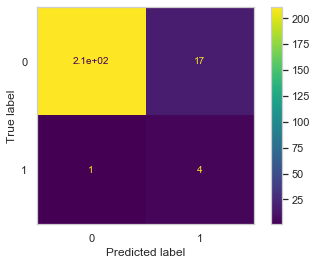

In [113]:
metrics.plot_confusion_matrix(pipe, X_test, y_test);

In [114]:
y_pred = pipe.predict_proba(X_test)[:,1]
y_pred[:5]

array([6.02132219e-07, 2.07561105e-06, 3.37762166e-06, 7.05817011e-06,
       3.59034281e-05])

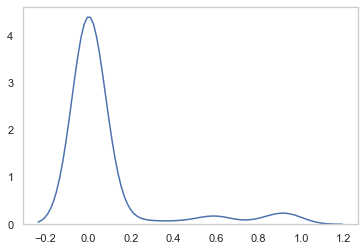

In [115]:
sns.kdeplot(y_pred);

In [116]:
metrics.confusion_matrix(y_test, y_pred > 0.09)

array([[201,  27],
       [  0,   5]])

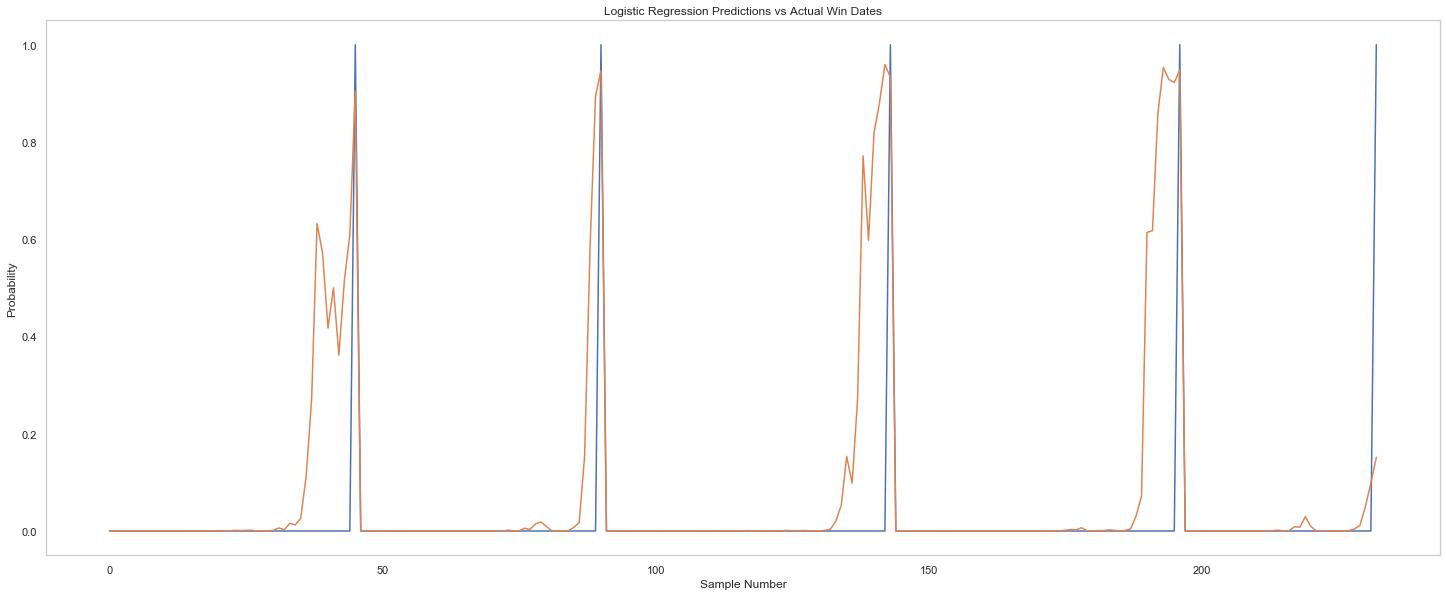

In [117]:
plt.figure(figsize=(20,8))
plt.plot(y_test.values)
plt.plot(y_pred)
plt.tight_layout()
plt.title('Logistic Regression Predictions vs Actual Win Dates')
plt.xlabel('Sample Number')
plt.ylabel('Probability')
plt.show()